In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import tqdm
import multiprocessing as mproc

import seaborn as sns

import util
import dtaidistance.dtw
from dtaidistance import dtw_visualisation as dtwvis

experiments = [{'dist_type': 'fit','n_bins': 3000, 'predefined_dists': True},
               {'dist_type': 'empirical','n_bins': 3000, 'predefined_dists': True}
              ]

In [2]:
def process_sample_input(input):
    results = {}
    tweets_per_file = util.load_data(**input)
    if len(tweets_per_file) == 0:
        return

    for e in experiments:
        d_type = e['dist_type']
        args = (e['n_bins'], tweets_per_file, d_type, e['predefined_dists'])
        results[d_type] = util.run(args)
        
    filename = f'../results/detect_drifts_m_{input["month"]}_' \
                + f'd_{input["days_range"][0]}_' \
                + f'{input["days_range"][1]}' \
                + f'_{int(time.time())}.pkl'
    pd.to_pickle(results, filename)
    print(filename)


In [4]:
input_params_full = []
for month in range(8,9):
    input_params_month = []
    for week in range(5):
        input_params_month.append(
            {   'days_range': (week*7+1,(week+1)*7+1 if week < 4 else 32), 
                'month': month,
                'hours_range': (0,24),
            }
        )
    input_params_full.append(input_params_month)

In [5]:
for input_month_params in input_params_full:
    args_gen = (input for input in input_month_params)
    p = mproc.Pool(processes=5)
    results = p.imap(process_sample_input, args_gen)

    tqdm.tqdm(total=len(input_month_params))

    p.close()
    p.join()

100%|██████████| 167/167 [20:42<00:00,  7.44s/it]


Number of tweets processed:  2178647


100%|██████████| 165/165 [23:20<00:00,  8.49s/it]


Number of tweets processed:  2118274


100%|██████████| 165/165 [2:02:16<00:00, 44.46s/it]  


Number of tweets processed:  2118274
../results/detect_drifts_m_8_d_8_15_1683497494.pkl


100%|██████████| 167/167 [2:21:17<00:00, 50.76s/it]


Number of tweets processed:  2178647
../results/detect_drifts_m_8_d_1_8_1683498475.pkl


In [6]:
import requests
from datetime import datetime
import time

hora = datetime.now()
hora = hora.strftime("%H:%M:%S")

url = 'https://api.dontpad.com/thalistdg'

headers = {}

body = {
    "text": f"Terminou {hora}",
    "captcha-token-v2":	"",
    "force": "true",
}


try:
    req = requests.post(url,headers=headers, params=body)
    print(req)
except Exception as ex:
    # raise ex
    time.sleep(5)
    req = requests.post(url,headers=headers, params=body)


<Response [200]>


In [ ]:
!shutdown

Shutdown scheduled for Sat 2023-05-06 03:14:51 -03, use 'shutdown -c' to cancel.


In [3]:
results = pd.read_pickle('../results/detect_drifts_m_8_d_1_8_1683498475.pkl')

results_times = {}
results_drifts = {}
dtw_dist_vs_minibatch = {}
dtw_fit_vs_empirical = {}

for exp_type in results:
    results_drifts[exp_type] = results[exp_type][0]
    results_times[exp_type] = results[exp_type][1]

    dtw_dist_vs_minibatch[exp_type] = {k:dtaidistance.dtw.distance(results_drifts[exp_type].get(k, []), results_drifts[exp_type]['mini-batch'])
                                       for k in util.approx_methods}


dtw_fit_vs_empirical = {'DTW - Fit vs Empirical':
                          {k:dtaidistance.dtw.distance(results_drifts['fit'].get(k, []), results_drifts['empirical'].get(k, []))
                                for k in results_drifts['fit'].keys()},
                        'qtd drifts Fit':
                          {k:len(results_drifts['fit'][k]) for k in results_drifts['fit'].keys()},
                        'qtd drifts Empirical':
                          {k:len(results_drifts['empirical'][k]) for k in results_drifts['fit'].keys()}
                        }


In [4]:
display(pd.DataFrame(results_times))

display(pd.DataFrame(dtw_fit_vs_empirical))

display(pd.DataFrame(dtw_dist_vs_minibatch))

,fit,empirical
Page Hinkley,1.612910,4.677087
GreedyKS,2.432328,860.421182
Reservoir Sampling,293.647385,7397.569982
IKS + RS,93.443855,100.274119


,DTW - Fit vs Empirical,qtd drifts Fit,qtd drifts Empirical
Page Hinkley,0.000000e+00,166,166
GreedyKS,3.121364e+04,166,162
Reservoir Sampling,7.527330e+05,160,49
IKS + RS,1.850943e+06,105,14
mini-batch,4.798529e+04,167,153


,fit,empirical
Page Hinkley,70669.214535,7.661151e+04
GreedyKS,13581.006111,4.486707e+04
Reservoir Sampling,53254.957084,7.179191e+05
IKS + RS,342989.221418,2.342083e+06


GreedyKS
Reservoir Sampling
IKS + RS
mini-batch


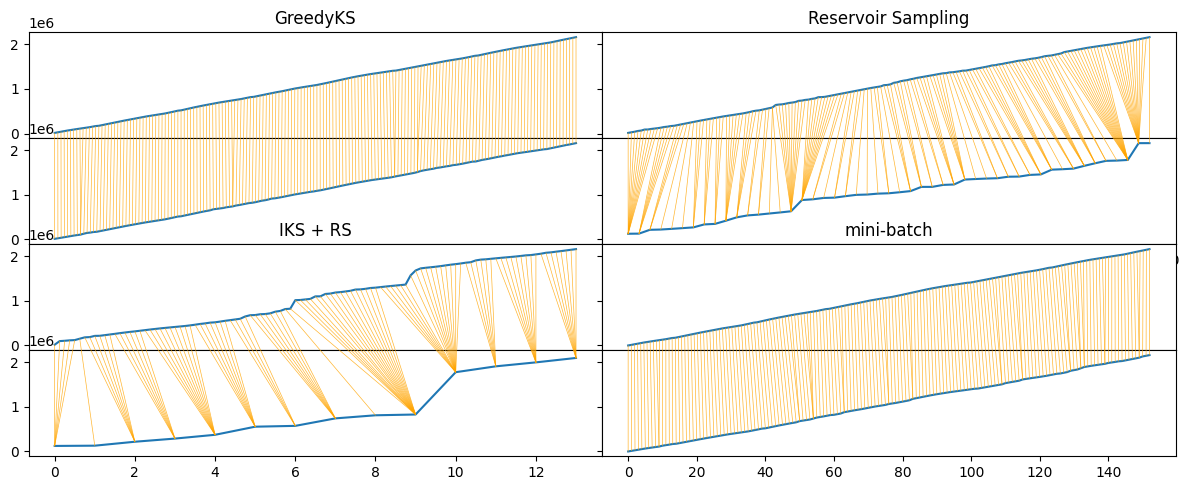

In [9]:
f_vs_e = [(results_drifts['fit'].get(k, []), results_drifts['empirical'].get(k, [])) for k in results_drifts['fit'].keys() if k != 'Page Hinkley']

figg, axs = plt.subplots(4, 2, figsize=(12,5), sharey=True, gridspec_kw={'hspace':0.0, 'wspace':0.0})

for i,k in enumerate(results_drifts['fit'].keys()):
    if k == 'Page Hinkley':
        continue
    s1 = np.array(results_drifts['fit'].get(k, []))
    s2 = np.array(results_drifts['empirical'].get(k, []))

    print(k)
    if i == 3 or i == 4:
        init = 2
    else:
        init = 0

    if i == 1:
        axs[0][0].set_title(k)
    elif i == 2:
        axs[0][1].set_title(k)
    elif i == 3:
        axs[2][0].set_title(k)
    elif i == 4:
        axs[2][1].set_title(k)

    path = dtaidistance.dtw.warping_path(s1, s2)
    dtwvis.plot_warping(s1, s2, path, fig=figg, axs=axs.T[(i-1)%2][init:])

In [37]:
file_names = ['detect_drifts_m_1_d_22_29_1683155601.pkl',
              'detect_drifts_m_1_d_29_32_1683155708.pkl',
              'detect_drifts_m_2_d_1_8_1683160209.pkl',
              'detect_drifts_m_2_d_8_15_1683160165.pkl',
              'detect_drifts_m_2_d_15_22_1683160111.pkl',
              'detect_drifts_m_2_d_22_29_1683160222.pkl',
              'detect_drifts_m_2_d_29_32_1683160325.pkl',
              'detect_drifts_m_3_d_1_8_1683218975.pkl',
              'detect_drifts_m_3_d_8_15_1683217859.pkl',
              'detect_drifts_m_3_d_15_22_1683219938.pkl',
              'detect_drifts_m_3_d_22_29_1683220334.pkl',
              'detect_drifts_m_3_d_29_32_1683217095.pkl',
              'detect_drifts_m_4_d_1_8_1683231359.pkl',
              'detect_drifts_m_4_d_8_15_1683230749.pkl',
              'detect_drifts_m_4_d_15_22_1683231360.pkl',
              'detect_drifts_m_4_d_22_29_1683232413.pkl',
              'detect_drifts_m_4_d_29_32_1683227988.pkl',
              'detect_drifts_m_5_d_1_8_1683243265.pkl',
              'detect_drifts_m_5_d_8_15_1683243191.pkl',
              'detect_drifts_m_5_d_15_22_1683242412.pkl',
              'detect_drifts_m_5_d_22_29_1683241935.pkl',
              'detect_drifts_m_5_d_29_32_1683236435.pkl',
              'detect_drifts_m_6_d_1_8_1683248575.pkl',
              'detect_drifts_m_6_d_8_15_1683343442.pkl',
              'detect_drifts_m_6_d_15_22_1683250960.pkl',
              'detect_drifts_m_6_d_22_29_1683252021.pkl',
              'detect_drifts_m_6_d_29_32_1683247203.pkl',
              'detect_drifts_m_7_d_1_8_1683294265.pkl',
              'detect_drifts_m_7_d_8_15_1683353629.pkl',
              'detect_drifts_m_7_d_15_22_1683295052.pkl',
              'detect_drifts_m_7_d_22_29_1683296056.pkl',
              'detect_drifts_m_7_d_29_32_1683289908.pkl',
              'detect_drifts_m_8_d_1_8_1683498475.pkl',
              'detect_drifts_m_8_d_8_15_1683497494.pkl',
              'detect_drifts_m_8_d_15_22_1683397061.pkl',
              'detect_drifts_m_8_d_22_29_1683396458.pkl',
              'detect_drifts_m_8_d_29_32_1683392343.pkl',
              'detect_drifts_m_9_d_1_8_1683405769.pkl',
              'detect_drifts_m_9_d_8_15_1683407329.pkl',
              'detect_drifts_m_9_d_15_22_1683406480.pkl',
              'detect_drifts_m_9_d_22_29_1683405600.pkl',
              'detect_drifts_m_9_d_29_32_1683399852.pkl',
              'detect_drifts_m_10_d_1_8_1683421974.pkl',
              'detect_drifts_m_10_d_8_15_1683419549.pkl',
              'detect_drifts_m_10_d_15_22_1683417274.pkl',
              'detect_drifts_m_10_d_22_29_1683418276.pkl',
              'detect_drifts_m_10_d_29_32_1683412878.pkl',
              'detect_drifts_m_11_d_1_8_1683429215.pkl',
              'detect_drifts_m_11_d_8_15_1683430757.pkl',
              'detect_drifts_m_11_d_15_22_1683432483.pkl',
              'detect_drifts_m_11_d_22_29_1683431999.pkl',
              'detect_drifts_m_11_d_29_32_1683424728.pkl',
              'detect_drifts_m_12_d_1_8_1683441243.pkl',
              'detect_drifts_m_12_d_8_15_1683441904.pkl',
              'detect_drifts_m_12_d_15_22_1683443181.pkl',
              'detect_drifts_m_12_d_22_29_1683441395.pkl',
              'detect_drifts_m_12_d_29_32_1683437793.pkl',
              ]

In [70]:
def read_all_weeks(file_names):
    results_all_fit = []
    results_all_empirical = []
    
    for file_name in file_names:
        results = pd.read_pickle(f'../results/{file_name}')

        results_times = {}
        results_drifts = {}
        dict_one_week = {}        

        for exp_type in results:
            results_drifts[exp_type] = results[exp_type][0]
            results_times[exp_type] = results[exp_type][1]

            dict_one_week[exp_type] = {k:dtaidistance.dtw.distance(results_drifts[exp_type].get(k, []), results_drifts[exp_type]['mini-batch'])
                                            for k in util.approx_methods}

        
        results_one_week_fit = pd.DataFrame(dict_one_week['fit'], index=[''])
        results_all_fit.append(results_one_week_fit)

        results_one_week_empirical = pd.DataFrame(dict_one_week['empirical'], index=[''])
        results_all_empirical.append(results_one_week_empirical)
        

    return pd.concat(results_all_fit), pd.concat(results_all_empirical)



In [77]:
results_dtw = read_all_weeks(file_names)

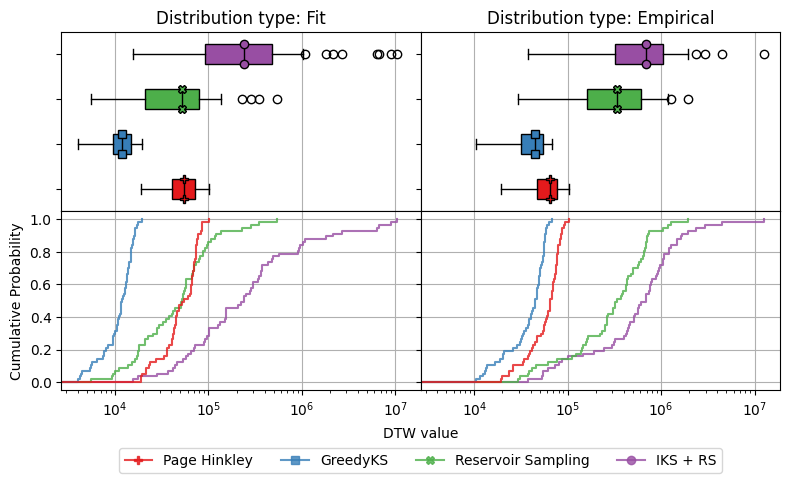

In [124]:
axes_prop_cycle = {
    'markersize':[8]*20,
    'linewidth':[1]*20,
    'markevery': [8]*20,
    'marker':['o', 'X', 's', 'P', 'D']*4,
    'color':sns.color_palette("Set1", 20)
}

def show_results(results, axs, d_type, legend=False):
    bps = axs[0].boxplot(results, vert=False, patch_artist=True)
    axs[0].set_xscale('log')
    axs[0].grid(axis='x')
    axs[0].set_title(r'Distribution type: ' + d_type)
    axs[0].set_yticklabels([])
    
    for i, j, k, l in zip(bps['boxes'], bps['medians'], axes_prop_cycle['marker'][3::-1], axes_prop_cycle['color']):
        i.set_facecolor(l)
        j.set_color('black')
        j.set_marker(k)
        j.set_markevery(1)
        j.set_markerfacecolor(l)
    
    sns.ecdfplot(results, log_scale=True, ax=axs[1], legend=legend, alpha=0.8, palette=axes_prop_cycle['color'][:4])
    axs[1].grid()
    axs[1].set_ylim([-0.05, 1.05])
    
    return bps

fig, axs = plt.subplots(2,2, sharex=True, figsize=(8,5), gridspec_kw={'hspace':0.0, 'wspace':0.0})

for e, (i,j, k) in enumerate(zip(results_dtw, axs.T, ['Fit', 'Empirical'])):
    zz = show_results(results_dtw[e], j, k, e == 0)
    j[0].set_yticklabels([])
    
    if e:
        j[1].set_yticklabels([])
        j[1].set_ylabel('')
    

axs[1,0].set_ylabel('Cumulative Probability')
axs[1,1].set_xlabel('DTW value')
axs[1,1].xaxis.set_label_coords(0, -.2)
sns.move_legend(axs[1,0], loc='lower center', ncol=5, bbox_to_anchor=(1.0, -0.5))

for i, j in zip(axs[1,0].legend_.legendHandles, axes_prop_cycle['marker'][3::-1]): 
    i.set_marker(j)
    i.set_markersize(6)


fig.tight_layout()

# fig.savefig('./data_pdf_files/call_center.pdf')